In [1]:
# from unsloth import FastLanguageModel
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    # "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    # "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    # "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    # "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    # "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    # "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    # "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    # "unsloth/Phi-3-mini-4k-instruct",          # Phi-3 2x faster!d
    # "unsloth/Phi-3-medium-4k-instruct",
    # "unsloth/gemma-2-9b-bnb-4bit",
    # "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model = AutoModelForCausalLM.from_pretrained(
   "/home/ljc/unsloth/lora_model",
    
)


model_ori = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3.1-8B",
  
)

/home/ljc/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


In [20]:
model_ori

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    

In [2]:
tokenizer_ori= AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3.1-8B")
tokenizer= AutoTokenizer.from_pretrained("/home/ljc/unsloth/lora_model")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


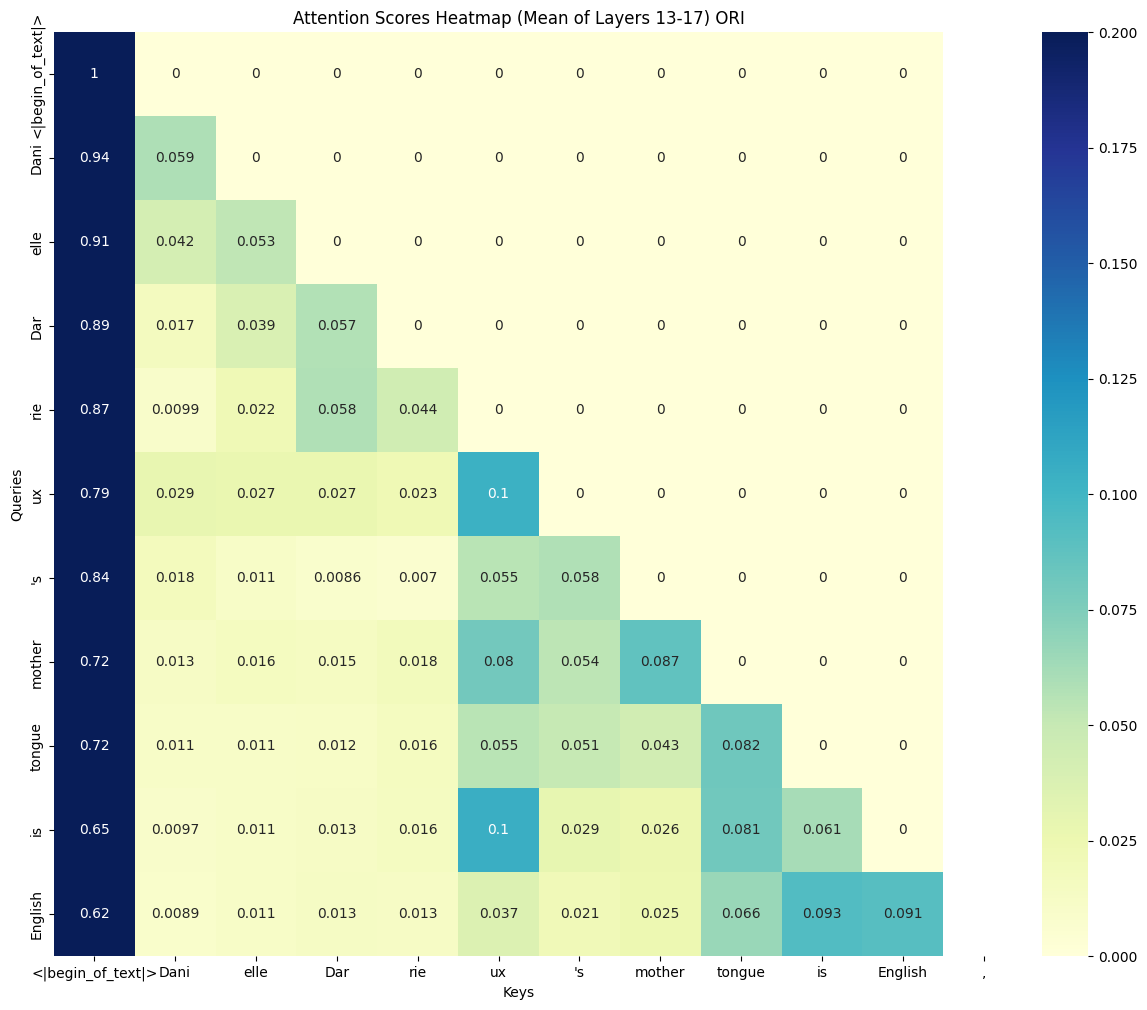

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns

# 输入文本
input_text = "Danielle Darrieux's mother tongue is English"

# 将输入文本编码为 token
inputs = tokenizer_ori(input_text, return_tensors="pt")
# FastLanguageModel.for_inference(model_ori) # Enable native 2x faster inference

# 生成新 token
generate_output = model_ori.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 1, output_attentions=True, return_dict_in_generate=True)
# generate_output = model_ori.generate(**inputs, max_new_tokens = 10, use_cache = True, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer_ori.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择第 13 到第 17 层的索引
selected_layers = range(13, 17)  # Python 索引从 0 开始，第 13 层索引为 12，第 17 层索引为 16

# 初始化一个矩阵来存储所选层的注意力值的均值
all_attention = []
max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])

for step in attentions:
    layer_attention = []
    for layer_index in selected_layers:
        attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
        attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
        pad_width = max_seq_length - attn.shape[-1]
        if pad_width > 0:
            attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        layer_attention.append(attn)
    # 对所选层的注意力值取均值
    mean_layer_attention = np.mean(layer_attention, axis=0)
    all_attention.append(mean_layer_attention)

# 将注意力值拼接成一个完整的矩阵
complete_attention = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.2)
plt.title('Attention Scores Heatmap (Mean of Layers 13-17) ORI')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()


/home/ljc/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/transformers/generation/utils.py:1885: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


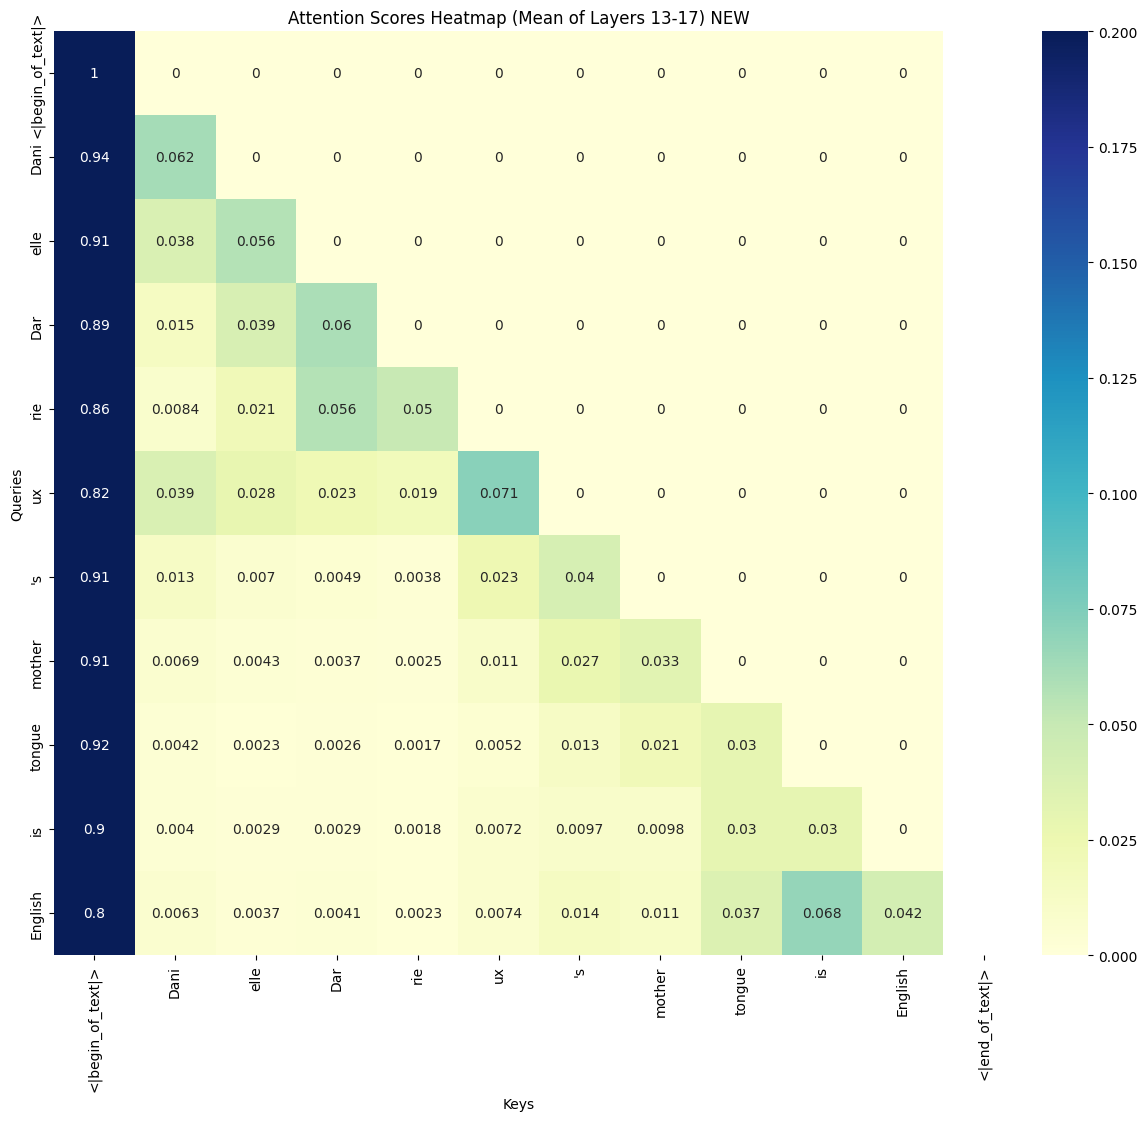

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
# 输入文本
input_text = "Danielle Darrieux's mother tongue is English"

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 1, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择第 13 到第 17 层的索引
selected_layers = range(13, 17)  # Python 索引从 0 开始，第 13 层索引为 12，第 17 层索引为 16

# 初始化一个矩阵来存储所选层的注意力值的均值
all_attention = []
max_seq_length = max([step[0][0][0].shape[-1] for step in attentions])

for step in attentions:
    layer_attention = []
    for layer_index in selected_layers:
        attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
        attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
        pad_width = max_seq_length - attn.shape[-1]
        if pad_width > 0:
            attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        layer_attention.append(attn)
    # 对所选层的注意力值取均值
    mean_layer_attention = np.mean(layer_attention, axis=0)
    all_attention.append(mean_layer_attention)

# 将注意力值拼接成一个完整的矩阵
complete_attention_new = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention_new, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.2)
plt.title('Attention Scores Heatmap (Mean of Layers 13-17) NEW')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()


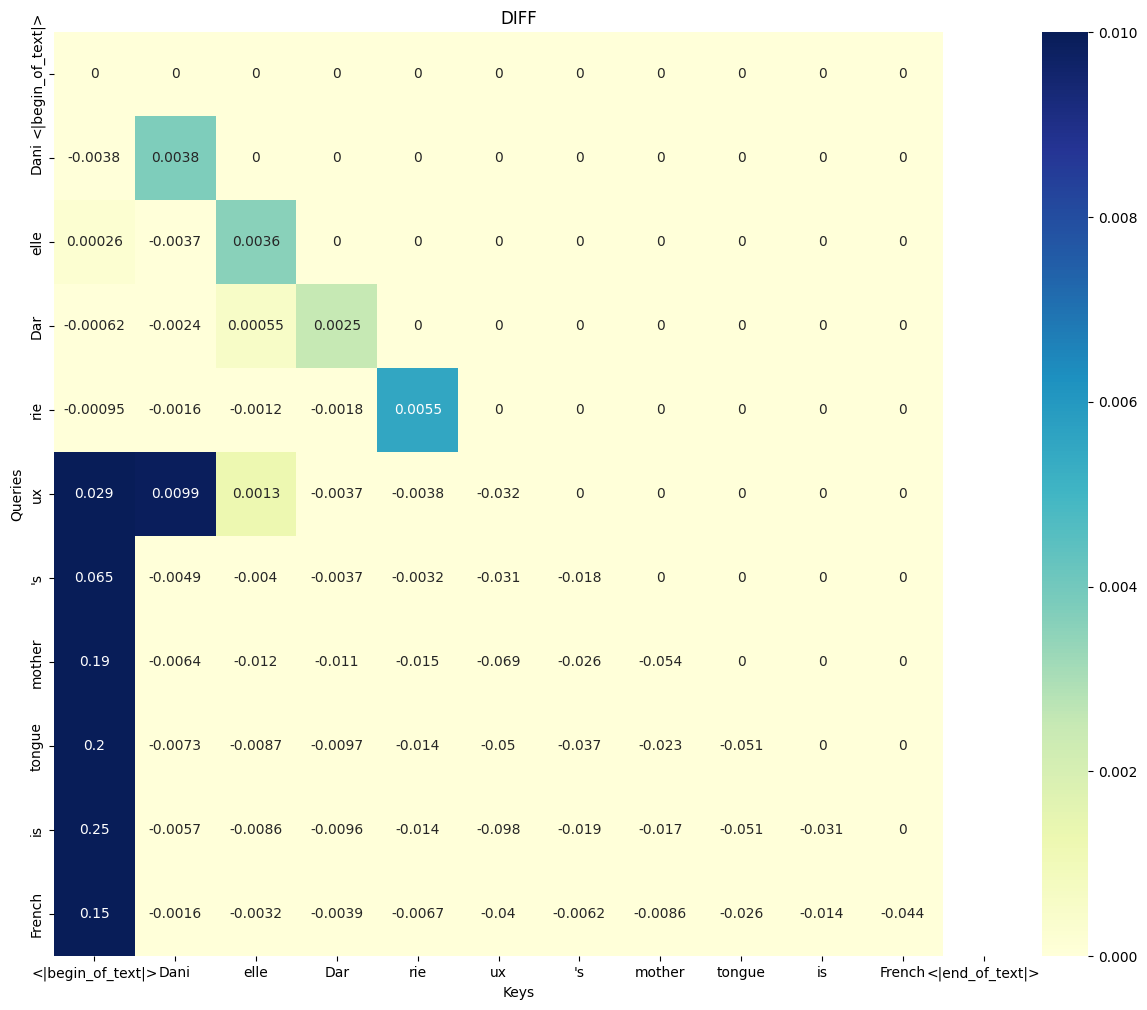

In [16]:
# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention_new-complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention_new.shape[0]], vmin=0, vmax=0.01)
plt.title('DIFF')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

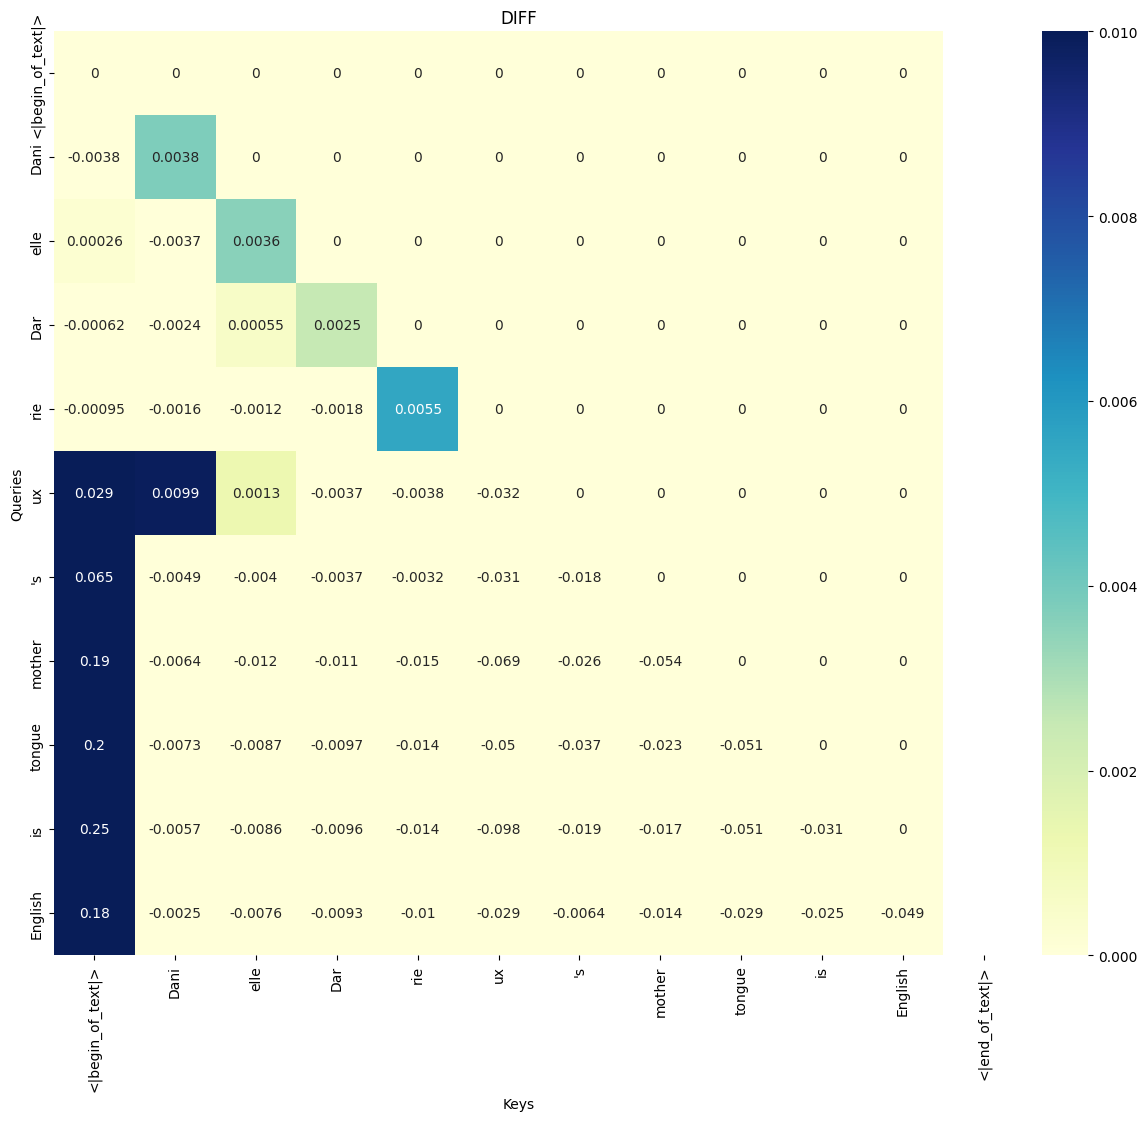

In [19]:
# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention_new-complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention_new.shape[0]], vmin=0, vmax=0.01)
plt.title('DIFF')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()